In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
from sklearn.cluster import SpectralClustering,KMeans,AgglomerativeClustering
from clustering import DiffusionGeometrySpectralClustering
from metric import acc
from PIL import Image
import numpy as np
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import struct
import time
import warnings
warnings.filterwarnings('ignore')
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.join(os.getcwd(), "smmc v-1.0"), nargout=0)

## 6. COIL-20 Dataset

In [3]:
data_dir = './coil-20'  

X = []
y = []

for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.png'):
        img = Image.open(os.path.join(data_dir, filename)).convert('L')
        img_array = np.array(img).flatten()  
        X.append(img_array)
        label = int(filename.split('__')[0].replace('obj', ''))
        y.append(label)

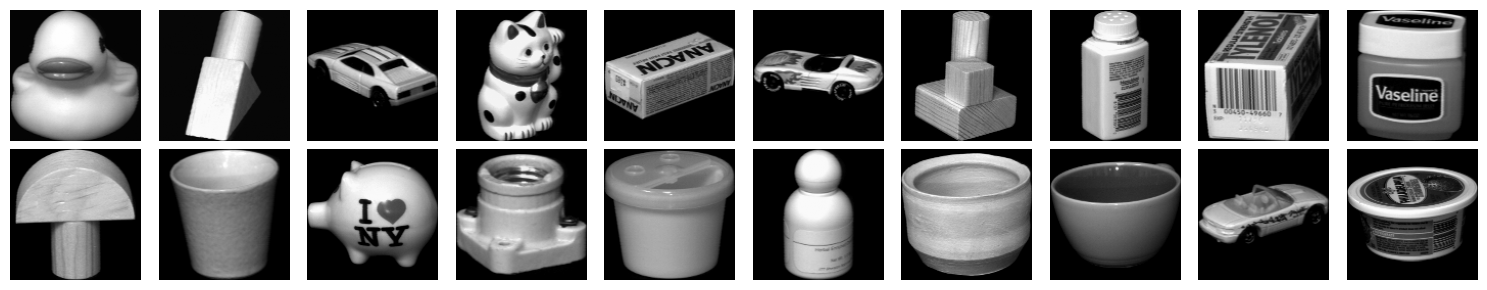

In [4]:
np.random.seed(42) 
classes = np.unique(y)

selected_images = []
selected_labels = []
for c in classes:
    idx = np.where(y == c)[0]
    chosen = np.random.choice(idx)  
    selected_images.append(X[chosen].reshape(128, 128))
    selected_labels.append(c)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig('figure5.png', dpi=600, bbox_inches='tight')
plt.show()

In [5]:
X = np.array(X)/255
y = np.array(y)

pca = PCA(n_components=10,random_state = 42)
X_pca = pca.fit_transform(X)
np.random.seed(42)
indices = np.random.permutation(len(X_pca))
X_pca = X_pca[indices]
y = y[indices]

In [6]:
## k-means
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters= 20,   
        init = 'random',
        random_state=42+i
    )
    y_pred = kmeans.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
kmeans_mean = np.mean(acc_list)
kmeans_std = np.std(acc_list)
kmeans_runtime= np.mean(runtime_list)

ACC interval: 0.670 ± 0.029, Run time: 0.197


In [7]:
## sc
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=20,          
        affinity='rbf',  
        assign_labels='kmeans', 
        gamma = 0.1,
        random_state=42+i
    )
    y_pred = sc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
sc_mean = np.mean(acc_list)
sc_std = np.std(acc_list)
sc_runtime= np.mean(runtime_list)

ACC interval: 0.678 ± 0.000, Run time: 5.996


In [8]:
## hc
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=20,
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
hc_mean = np.mean(acc_list)
hc_std = np.std(acc_list)
hc_runtime= np.mean(runtime_list)

ACC interval: 0.694 ± 0.000, Run time: 0.104


In [9]:
# SMMC
acc_list = []
runtime_list = []
X_matlab = matlab.double(X_pca.T.tolist())
for i in range(10):
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([20]),   # nClusts
        matlab.double([1]),   # ppca_dim
        matlab.double([15]),  # ncentres = M
        matlab.double([20]),  # knn = k
        matlab.double([8]),   # power = o
        matlab.double([42+i]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
smmc_mean = np.mean(acc_list)
smmc_std = np.std(acc_list)
smmc_runtime= np.mean(runtime_list)

ACC interval: 0.707 ± 0.026, Run time: 5.316


In [10]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_pca,20,M = 2, K = 20,o = 4,random_state = 42+i)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
dgmmsc_mean = np.mean(acc_list)
dgmmsc_std = np.std(acc_list)
dgmmsc_runtime= np.mean(runtime_list)

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.58s/it]

ACC interval: 0.760 ± 0.014, Run time: 29.512


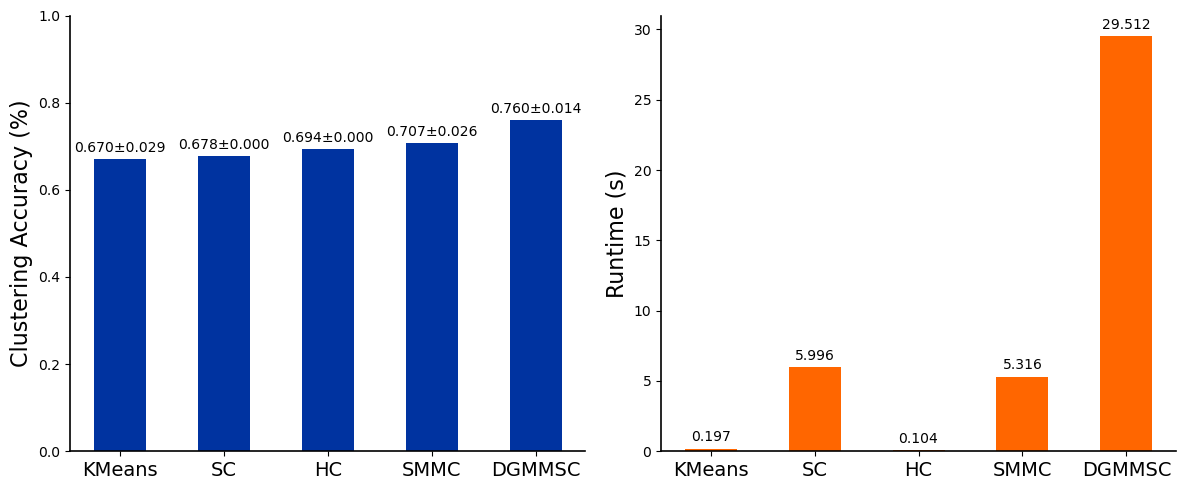

In [28]:
methods = ['KMeans', 'SC', 'HC', 'SMMC', 'DGMMSC']
accuracy = np.array([kmeans_mean, sc_mean, hc_mean, smmc_mean, dgmmsc_mean])
std_acc  = np.array([kmeans_std, sc_std, hc_std, smmc_std, dgmmsc_std])
runtime  = np.array([kmeans_runtime, sc_runtime, hc_runtime, smmc_runtime, dgmmsc_runtime])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars1 = axes[0].bar(methods, accuracy, color='#0033A0', width=0.5)
for bar, accs, s in zip(bars1, accuracy, std_acc):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{accs:.3f}±{s:.3f}', ha='center', va='bottom', fontsize=10)

axes[0].set_ylabel('Clustering Accuracy (%)',fontsize = 16)
axes[0].set_ylim(0, 1.0)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(1.2)
axes[0].spines['bottom'].set_linewidth(1.2)

bars2 = axes[1].bar(methods, runtime, color='#FF6600', width=0.5)
for bar, rt in zip(bars2, runtime):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.3,
                 f'{rt:.3f}', ha='center', va='bottom', fontsize=10)

axes[1].set_ylabel('Runtime (s)',fontsize = 16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(1.2)
axes[1].spines['bottom'].set_linewidth(1.2)
axes[0].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig('figure6.png', dpi=600, bbox_inches='tight')
plt.show()

## 7. MNIST Dataset

In [30]:
file_path = "./MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
with open(file_path, 'rb') as f:
    magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
    print(f"Magic: {magic}, Images: {num_images}, Size: {rows}x{cols}")
    
    data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(num_images, rows, cols)

file_path_label = "./MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"
with open(file_path_label, 'rb') as f:
    magic, num_labels = struct.unpack(">II", f.read(8))
    print(f"Magic: {magic}, Number of labels: {num_labels}")

    y = np.frombuffer(f.read(), dtype=np.uint8)
X = data.reshape(data.shape[0],-1)/255
pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X)

Magic: 2051, Images: 10000, Size: 28x28
Magic: 2049, Number of labels: 10000


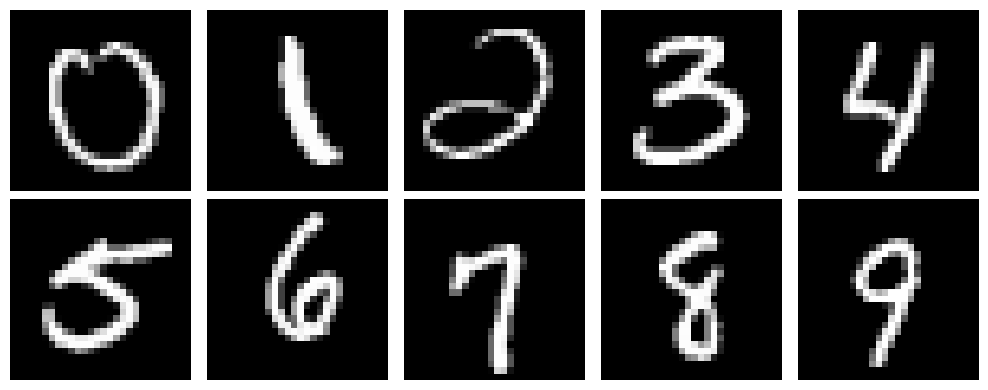

In [31]:
np.random.seed(42) 
classes = np.unique(y)

selected_images = []
selected_labels = []
for c in classes:
    idx = np.where(y == c)[0]
    chosen = np.random.choice(idx) 
    selected_images.append(X[chosen].reshape(28, 28))
    selected_labels.append(c)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig('figure7.png', dpi=600, bbox_inches='tight')
plt.show()

In [32]:
## kmeans
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=10,       
        init='random',
        random_state=42+i     
    )
    y_pred = kmeans.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
kmeans_mean = np.mean(acc_list)
kmeans_std = np.std(acc_list)
kmeans_runtime= np.mean(runtime_list)

ACC interval: 0.547 ± 0.003, Run time: 1.975


In [33]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=10,         
        affinity='rbf',  
        assign_labels='kmeans', 
        gamma = 0.01,
        random_state=42+i
    )
    y_pred = sc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
sc_mean = np.mean(acc_list)
sc_std = np.std(acc_list)
sc_runtime= np.mean(runtime_list)

ACC interval: 0.543 ± 0.000, Run time: 120.061


In [34]:
# HC
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=10,
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
hc_mean = np.mean(acc_list)
hc_std = np.std(acc_list)
hc_runtime= np.mean(runtime_list)

ACC interval: 0.679 ± 0.000, Run time: 10.170


In [35]:
# SMMC
acc_list = []
runtime_list = []
X_matlab = matlab.double(X_pca.T.tolist())
for i in range(10):
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([10]),   # nClusts
        matlab.double([3]),   # ppca_dim
        matlab.double([10]),  # ncentres = M
        matlab.double([19]),  # knn = k
        matlab.double([8]),   # power = o
        matlab.double([42+i]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
smmc_mean = np.mean(acc_list)
smmc_std = np.std(acc_list)
smmc_runtime= np.mean(runtime_list)

ACC interval: 0.633 ± 0.049, Run time: 107.986


In [36]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_pca,10,M = 27, K = 20,o = 4,random_state = 42+i)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
dgmmsc_mean = np.mean(acc_list)
dgmmsc_std = np.std(acc_list)
dgmmsc_runtime= np.mean(runtime_list)

Spectral Clustering: 100%|██████████████████████████████████████████████████████████████| 4/4 [07:51<00:00, 117.99s/it]


ACC interval: 0.776 ± 0.013, Run time: 605.369


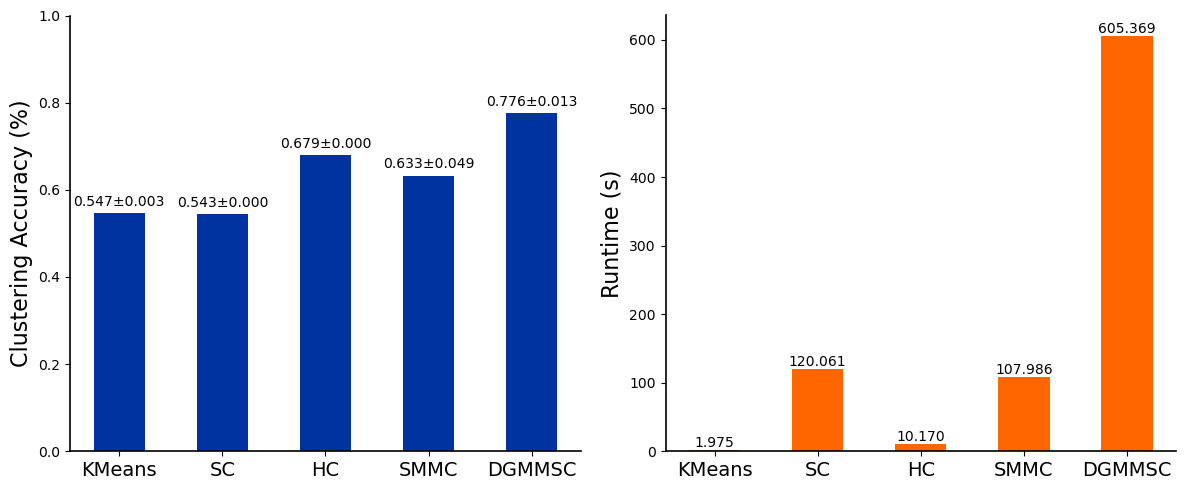

In [37]:
methods = ['KMeans', 'SC', 'HC', 'SMMC', 'DGMMSC']
accuracy = np.array([kmeans_mean, sc_mean, hc_mean, smmc_mean, dgmmsc_mean])
std_acc  = np.array([kmeans_std, sc_std, hc_std, smmc_std, dgmmsc_std])
runtime  = np.array([kmeans_runtime, sc_runtime, hc_runtime, smmc_runtime, dgmmsc_runtime])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars1 = axes[0].bar(methods, accuracy, color='#0033A0', width=0.5)
for bar, accs, s in zip(bars1, accuracy, std_acc):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{accs:.3f}±{s:.3f}', ha='center', va='bottom', fontsize=10)

axes[0].set_ylabel('Clustering Accuracy (%)',fontsize = 16)
axes[0].set_ylim(0, 1.0)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(1.2)
axes[0].spines['bottom'].set_linewidth(1.2)

bars2 = axes[1].bar(methods, runtime, color='#FF6600', width=0.5)
for bar, rt in zip(bars2, runtime):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.3,
                 f'{rt:.3f}', ha='center', va='bottom', fontsize=10)

axes[1].set_ylabel('Runtime (s)',fontsize = 16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(1.2)
axes[1].spines['bottom'].set_linewidth(1.2)
axes[0].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig('figure8.png', dpi=600, bbox_inches='tight')
plt.show()

## 3. Extend Yale B

In [39]:
root = os.path.join(os.getcwd(), "CroppedYale")
np.random.seed(42)
n = 3
all_persons = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]

selected_persons = np.random.choice(all_persons, size=n, replace=False)

images = []
labels = []

for person_folder in selected_persons:
    person_path = os.path.join(root, person_folder)
    match = re.search(r"yaleB(\d+)", person_folder)
    if match:
        label = int(match.group(1))
    else:
        continue
    for file in os.listdir(person_path):
        if file.endswith(".pgm") and (len(file.split('_')) != 3):
            file_path = os.path.join(person_path, file)
            img = Image.open(file_path).convert("L") 
            
            img_array = np.array(img)
            
            images.append(img_array)
            labels.append(label)
            
X = np.array(images)   
y = np.array(labels)  

X = X.reshape(X.shape[0], -1) / 255.0

perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

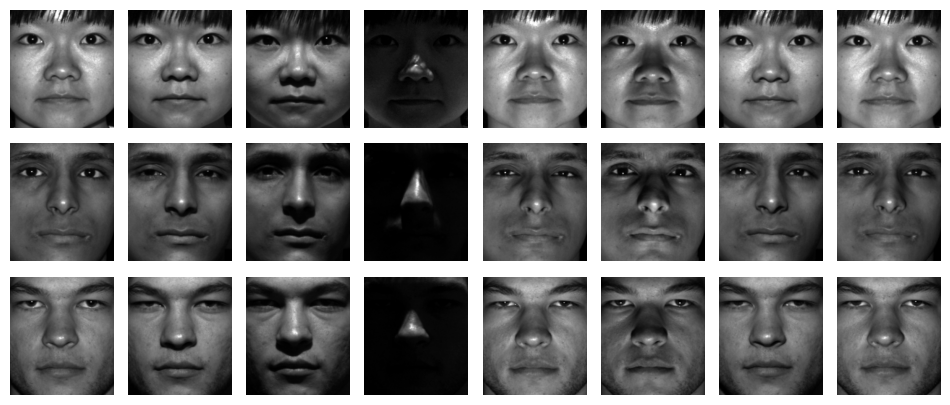

In [41]:
person_images = {}

for person_folder in selected_persons:
    person_path = os.path.join(root, person_folder)
    match = re.search(r"yaleB(\d+)", person_folder)
    if not match:
        continue
    label = int(match.group(1))
    person_images[label] = {}
    
    for file in os.listdir(person_path):
        if file.endswith(".pgm") and (len(file.split('_')) != 3):
            condition = "_".join(file.split("_")[1:])  
            img = Image.open(os.path.join(person_path, file)).convert("L")
            img_array = np.array(img)
            person_images[label][condition] = img_array

common_conditions = set.intersection(
    *[set(person_images[label].keys()) for label in person_images]
)

n_cols = 8
chosen_conditions = sorted(list(common_conditions))[:n_cols]

n_rows = len(person_images)

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))

for row, label in enumerate(sorted(person_images.keys())):
    for col, cond in enumerate(chosen_conditions):
        img = person_images[label][cond]
        
        ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figure9.png', dpi=600, bbox_inches='tight')
plt.show()

In [42]:
## kmeans
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=3,     
        init='random',
        random_state=42+i   
    )
    y_pred = kmeans.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
kmeans_mean = np.mean(acc_list)
kmeans_std = np.std(acc_list)
kmeans_runtime= np.mean(runtime_list)

ACC interval: 0.403 ± 0.003, Run time: 0.035


In [43]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=3,        
        affinity='rbf', 
        assign_labels='kmeans', 
        gamma=0.01,
        random_state=42+i
    )
    y_pred = sc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
sc_mean = np.mean(acc_list)
sc_std = np.std(acc_list)
sc_runtime= np.mean(runtime_list)

ACC interval: 0.505 ± 0.000, Run time: 0.064


In [44]:
# HC
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=3,
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_pca)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
hc_mean = np.mean(acc_list)
hc_std = np.std(acc_list)
hc_runtime= np.mean(runtime_list)

ACC interval: 0.359 ± 0.000, Run time: 0.005


In [45]:
# SMMC
acc_list = []
runtime_list = []
X_matlab = matlab.double(X_pca.T.tolist())
for i in range(10):
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([3]),   # nClusts
        matlab.double([9]),   # ppca_dim
        matlab.double([5]),  # M
        matlab.double([12]),  # K
        matlab.double([4]),   # o
        matlab.double([42+i]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

smmc_mean = np.mean(acc_list)
smmc_std = np.std(acc_list)
smmc_runtime= np.mean(runtime_list)

ACC interval: 0.474 ± 0.002, Run time: 0.468


In [46]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(10):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_pca,3,M = 2, K = 4, o = 3,random_state = 42+i) 
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")
dgmmsc_mean = np.mean(acc_list)
dgmmsc_std = np.std(acc_list)
dgmmsc_runtime= np.mean(runtime_list)

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22it/s]

ACC interval: 0.569 ± 0.016, Run time: 0.806


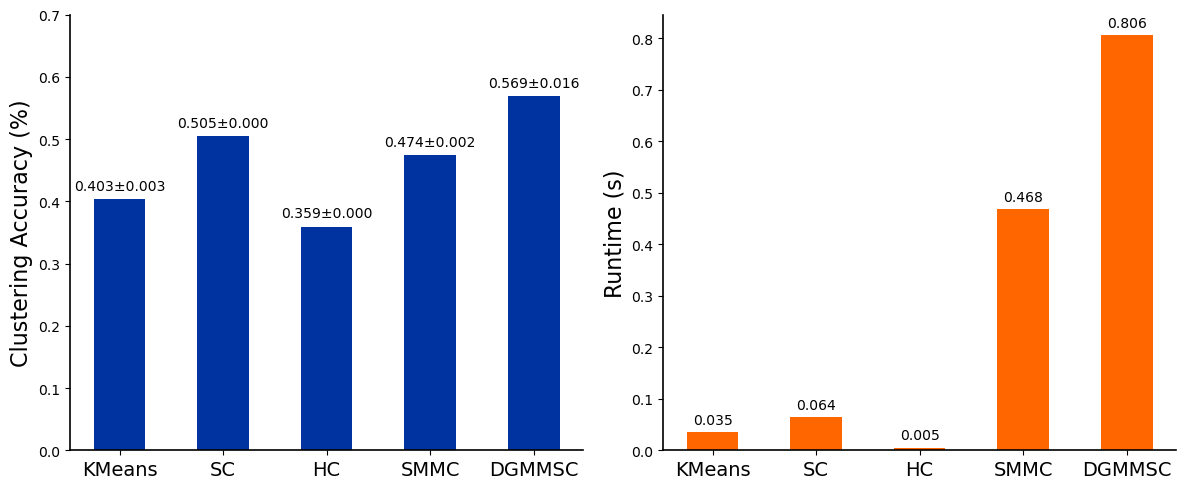

In [47]:
methods = ['KMeans', 'SC', 'HC', 'SMMC', 'DGMMSC']
accuracy = np.array([kmeans_mean, sc_mean, hc_mean, smmc_mean, dgmmsc_mean])
std_acc  = np.array([kmeans_std, sc_std, hc_std, smmc_std, dgmmsc_std])
runtime  = np.array([kmeans_runtime, sc_runtime, hc_runtime, smmc_runtime, dgmmsc_runtime])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars1 = axes[0].bar(methods, accuracy, color='#0033A0', width=0.5)
for bar, accs, s in zip(bars1, accuracy, std_acc):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{accs:.3f}±{s:.3f}', ha='center', va='bottom', fontsize=10)

axes[0].set_ylabel('Clustering Accuracy (%)',fontsize = 16)
axes[0].set_ylim(0, 0.7)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(1.2)
axes[0].spines['bottom'].set_linewidth(1.2)

bars2 = axes[1].bar(methods, runtime, color='#FF6600', width=0.5)
for bar, rt in zip(bars2, runtime):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{rt:.3f}', ha='center', va='bottom', fontsize=10)

axes[1].set_ylabel('Runtime (s)',fontsize = 16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(1.2)
axes[1].spines['bottom'].set_linewidth(1.2)
axes[0].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig('figure10.png', dpi=600, bbox_inches='tight')
plt.show()